In [2]:
from tsai.all import *
import sklearn.metrics as skm
import sklearn.metrics as skm
from fastai.callback.tracker import SaveModelCallback
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'
my_setup()


os              : Linux-5.15.0-126-generic-x86_64-with-glibc2.35
python          : 3.10.13
tsai            : 0.3.9
fastai          : 2.7.17
fastcore        : 1.5.29
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 4090'])
cpu cores       : 16
threads per cpu : 1
RAM             : 125.64 GB
GPU memory      : [23.99] GB


## 1. prepare data

In [4]:
data_root = 'data'
label_col = 'class'

class_num = '5_class'
sp_mode = 's'

save_root = os.path.join('tsai_Models', f'{class_num}__{sp_mode}')
if not os.path.exists(save_root):
    os.makedirs(save_root)

train_val_data_path = os.path.join(f'data/{class_num}', f'train_val.csv')
test_data_path = os.path.join(f'data/{class_num}', f'test.csv')
train_val_data = pd.read_csv(train_val_data_path)
test_data = pd.read_csv(test_data_path)
train_val_data.drop(columns=[c for c in train_val_data.columns if c.startswith('p')], inplace=True)
test_data.drop(columns=[c for c in test_data.columns if c.startswith('p')], inplace=True)
print(train_val_data.shape, test_data.shape)


(45000, 33) (5000, 33)


In [3]:
random_seed = 29
train_data, val_data = train_test_split(train_val_data, test_size=5000, random_state=random_seed, stratify=train_val_data['old_class'])
train_data.drop(columns=['old_class'], inplace=True)
val_data.drop(columns=['old_class'], inplace=True)
test_data.drop(columns=['old_class'], inplace=True)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
print(train_data.shape, val_data.shape)


(40000, 32) (5000, 32)


In [4]:
X_train = train_data.drop(columns=['id', label_col]).values
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# y_train = np.array([class2idx[c] for c in train_data[label_col].values])
y_train = train_data[label_col].values

X_val = val_data.drop(columns=['id', label_col]).values
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
# y_val = np.array([class2idx[c] for c in val_data[label_col].values])
y_val = val_data[label_col].values

X_test = test_data.drop(columns=['id', label_col]).values
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# y_test = np.array([class2idx[c] for c in test_data[label_col].values])
y_test = test_data[label_col].values

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((40000, 1, 30), (40000,), (5000, 1, 30), (5000,), (5000, 1, 30), (5000,))

In [5]:
X, y, splits = combine_split_data([X_train, X_val], [y_train, y_val])
splits

((#40000) [0,1,2,3,4,5,6,7,8,9...],
 (#5000) [40000,40001,40002,40003,40004,40005,40006,40007,40008,40009...])

## 2. inspect data

In [6]:
label_counts = collections.Counter(y_val)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'mm_2': 1000, 'second': 1001, 'mm_1': 1000, 'zero': 1000, 'first': 999}
Naive Accuracy: 20.02%


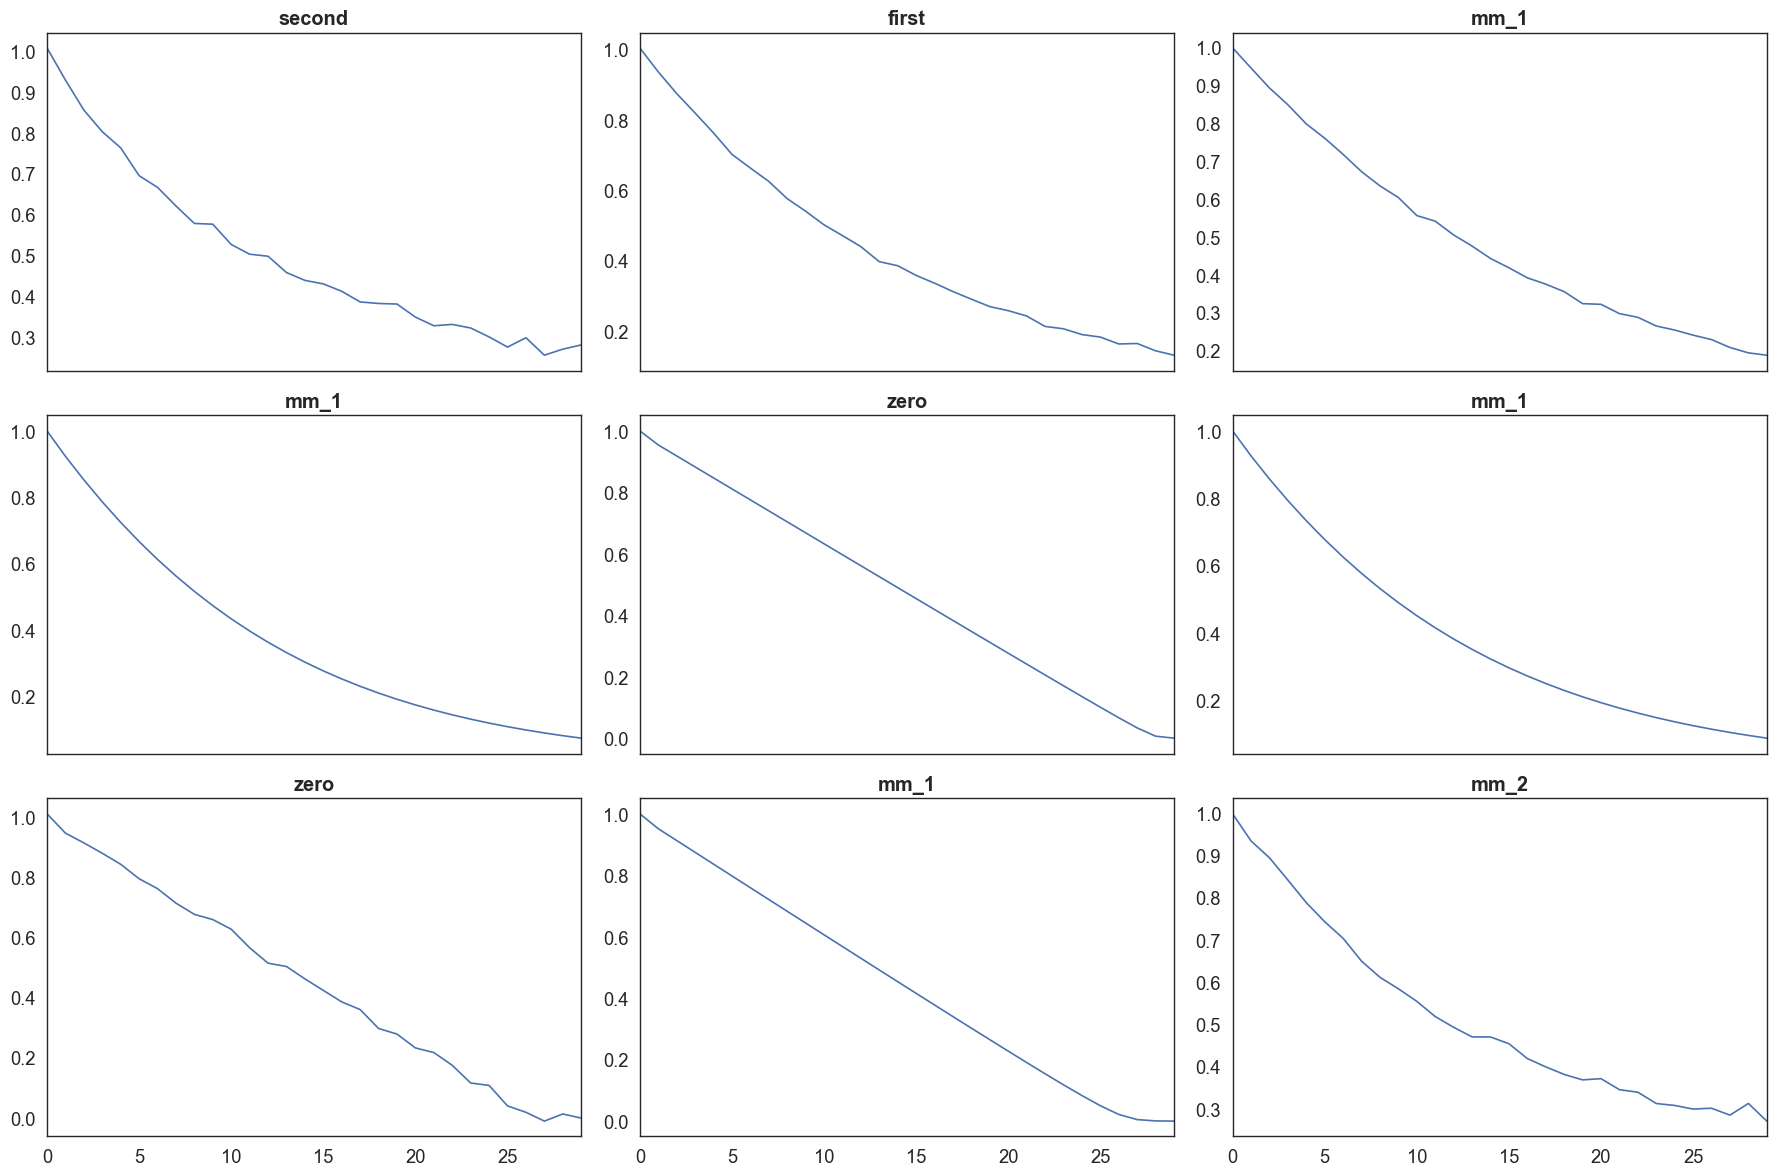

In [7]:
bs = 512

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
test_ds = dls.dataset.add_test(X_test, y_test)
test_dl = dls.new(test_ds)
dls.show_batch()

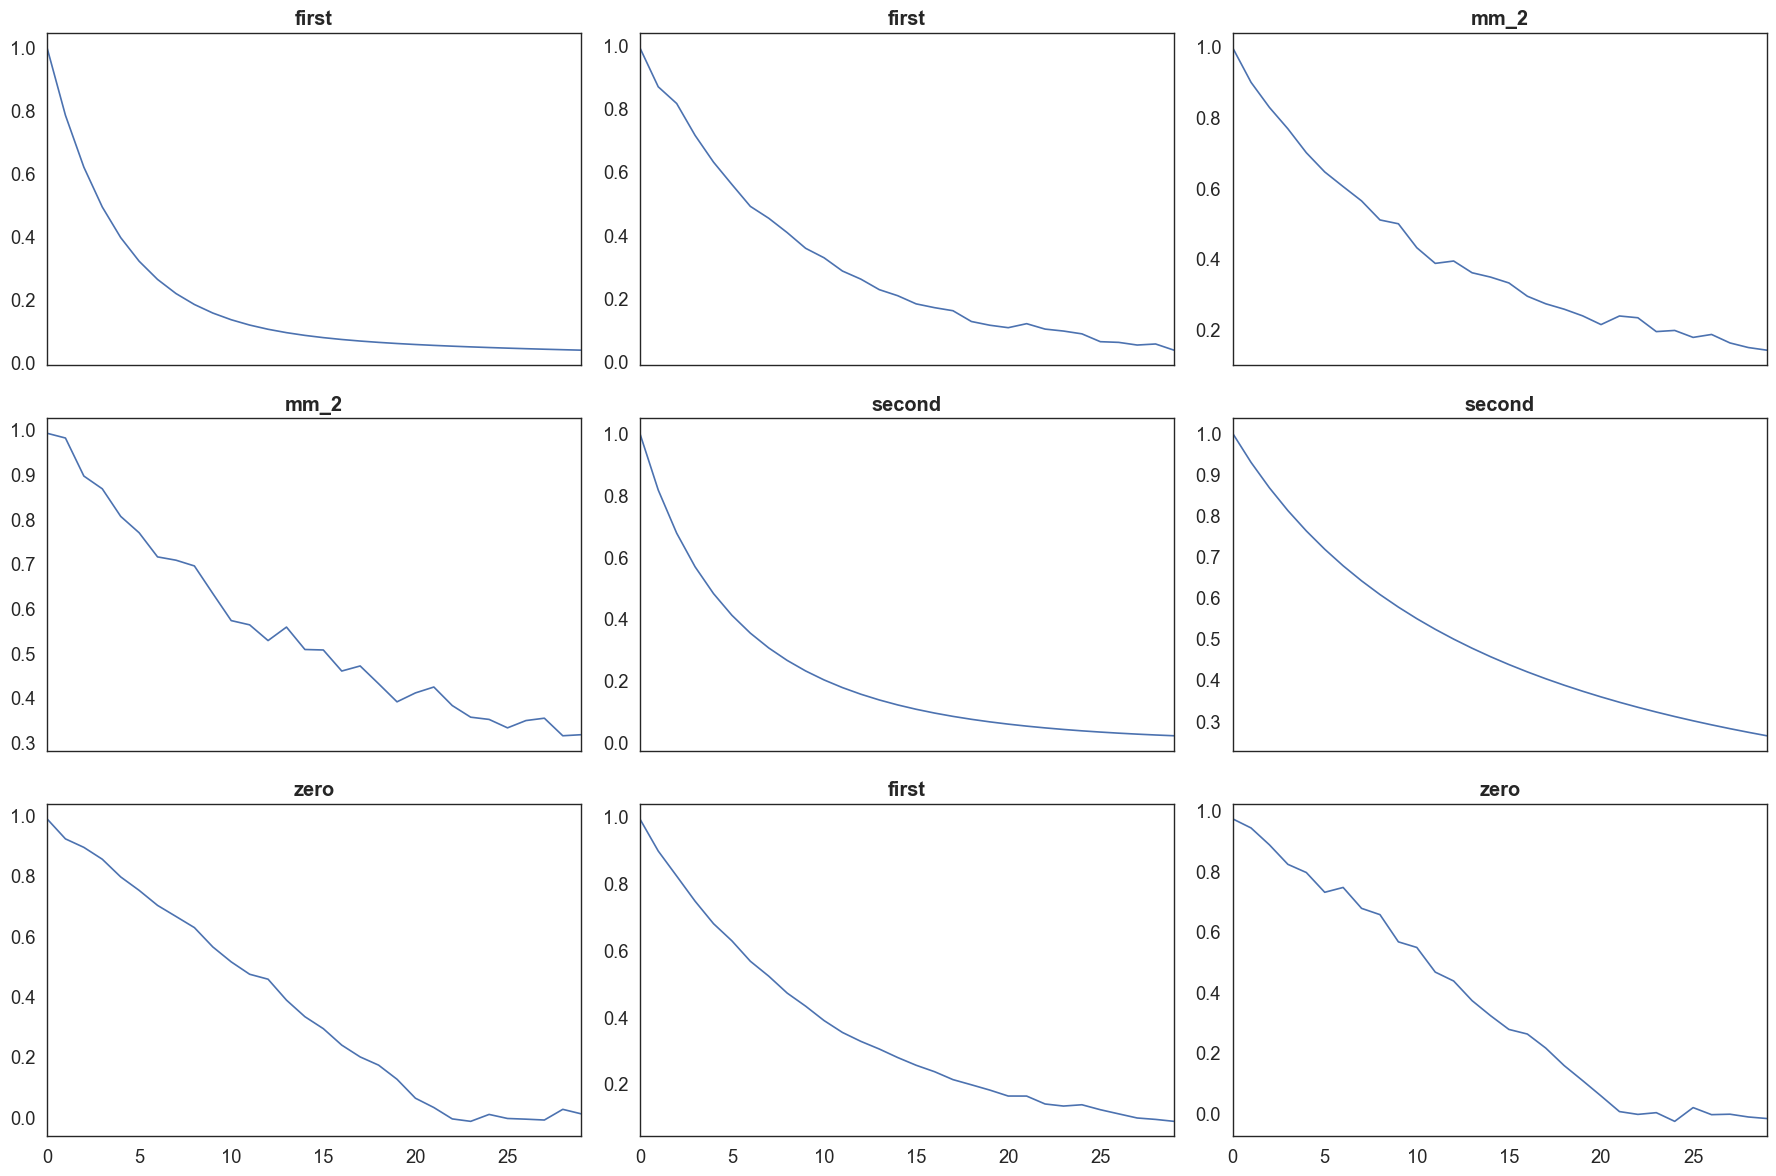

In [8]:
dls.show_batch()

## 3. Archs comparison

In [9]:
repeat_num = 3

archs = [
    # (FCN, {}), 
    (ResNet, {}), 
    # # (xresnet1d34, {}), 
    (ResCNN, {}), 
    (RNN, {'n_layers':1, 'bidirectional': False}),
    # (RNN, {'n_layers':2, 'bidirectional': False}),
    # (RNNPlus, {'n_layers':1, 'bidirectional': False}),
    # # (RNNPlus, {'n_layers':2, 'bidirectional': False}),
    # (GRU, {'n_layers':1, 'bidirectional': False}),
    # # (GRU, {'n_layers':2, 'bidirectional': False}),
    # (GRUPlus, {'n_layers':1, 'bidirectional': False}),
    # # (GRUPlus, {'n_layers':2, 'bidirectional': False}),
    (LSTM, {'n_layers':1, 'bidirectional': False}), 
    # (LSTM, {'n_layers':2, 'bidirectional': False}),
    # (LSTM, {'n_layers':3, 'bidirectional': False}),
    # (LSTMPlus, {'n_layers':1, 'bidirectional': False}),
    # (LSTMPlus, {'n_layers':2, 'bidirectional': False}),
    (LSTM, {'n_layers':1, 'bidirectional': True}), 
    # (LSTM, {'n_layers':2, 'bidirectional': True}), 
    # (LSTM, {'n_layers':3, 'bidirectional': True}),
    # (LSTMPlus, {'n_layers':1, 'bidirectional': True}),
    # (LSTMPlus, {'n_layers':2, 'bidirectional': True}),
    # (LSTM_FCN, {}), 
    # # (LSTM_FCN, {'shuffle': False}), 

    (InceptionTime, {}),
    # (InceptionTime, {

    # }),
    (InceptionTimePlus, {}),
    # (InceptionTimePlus, {

    # }),
    (XceptionTime, {}), 
    (XceptionTimePlus, {}),
    # (OmniScaleCNN, {}), 
    (mWDN, {}),
    # (mWDN, {
    #     'levels': 2,
    # }),
    # (mWDN, {
    #     'levels': 3,
    # }),
    # (mWDN, {
    #     'levels': 4,
    # }),
    (mWDNPlus, {}),
    # (mWDNPlus, {
    #     'levels': 2,
    # }),
    # (mWDNPlus, {
    #     'levels': 3,
    # }),  
    # (mWDNPlus, {
    #     'levels': 4,
    # }),
    # (mWDNPlus, {
    #     'levels': 4,
    #     'depth': 6,
    #     'ks': 40,
    #     'conv_dropout': 0.,
    #     'fc_dropout': 0.,
    #     'nf': 32,
    # }),
    # (mWDNPlus, {
    #     'levels': 3,
    #     'depth': 8,
    #     'ks': 40,
    #     'conv_dropout': 0.2,
    #     'fc_dropout': 0.0,
    #     'nf': 32,
    # }),
    (TST, {}),
    (TSTPlus, {}),

    # (TSPerceiver, {}),
    # (TSiTPlus, {}),
    # (PatchTST, {}),
    # (RNN_FCNPlus, {}),
    # (TransformerRNNPlus, {}),
    # (TransformerGRUPlus, {}),
    # (TransformerLSTMPlus, {}),

]

if os.path.exists(os.path.join(save_root, 'archs_results.csv')):
    results = pd.read_csv(os.path.join(save_root, 'archs_results.csv'))
else:
    results = pd.DataFrame(columns=[
        'arch',
        'repeat_id',
        'hyperparams', 
        'total_params', 
        'train_loss', 
        'valid_loss', 
        'val_accuracy', 
        'val_best_accuracy', 
        'test_accuracy', 
        'test_precision',
        'test_recall',
        'test_f1',
        'test_roc_auc', 
        'test_mcc',
        'time',
    ])
if os.path.exists(os.path.join(save_root, 'all_train_results.pkl')):
    with open(os.path.join(save_root, 'all_train_results.pkl'), 'rb') as f:
        all_train_results = pickle.load(f)
else:
    all_train_results = {}

if os.path.exists(os.path.join(save_root, 'all_test_results.json')):
    with open(os.path.join(save_root, 'all_test_results.json'), 'r') as f:
        all_test_results_json = json.load(f)
else:
    all_test_results_json = {}
if os.path.exists(os.path.join(save_root, 'all_test_results.pkl')):
    with open(os.path.join(save_root, 'all_test_results.pkl'), 'rb') as f:
        all_test_results = pickle.load(f)
else:
    all_test_results = {}

for i, (arch, k) in enumerate(archs):
    for repeat_id in range(repeat_num):
        model = create_model(arch, dls=dls, **k)
        name = f'{arch.__name__}__{repeat_id}'
        while name in all_test_results_json:
            name += '_'
        print(name)
        learn = Learner(dls, model, metrics=accuracy, model_dir=save_root, cbs=[ShowGraph(), SaveModelCallback(monitor='accuracy', fname=name)])
        start = time.time()

        lr_max = 0.001
        epoch = 100
        
        learn.fit_one_cycle(epoch, lr_max)
        elapsed = time.time() - start

        all_train_results[name] = learn.recorder.values

        vals = learn.recorder.values[-1]
        best_accuracy = max([item[2] for item in learn.recorder.values])
        
        model_best_epoch = learn.load(name)
        # eval on test set
        test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
        test_accuracy = skm.accuracy_score(test_targets, test_preds)
        test_precision = skm.precision_score(test_targets, test_preds, average="macro")
        test_recall = skm.recall_score(test_targets, test_preds, average="macro")
        test_f1 = skm.f1_score(test_targets, test_preds, average="macro")
        test_roc_auc = skm.roc_auc_score(test_targets, test_probas, average="macro", multi_class="ovr")
        test_mcc = skm.matthews_corrcoef(test_targets, test_preds)
        test_confusion_matrix = skm.confusion_matrix(test_targets, test_preds)
        
        all_test_results_json[name] = {
            # 'test_probas': test_probas.tolist(),
            # 'test_targets': test_targets.tolist(),
            # 'test_preds': test_preds.tolist(),
            'hyper_params': k,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'test_roc_auc': test_roc_auc,
            'test_mcc': test_mcc,
            # 'test_confusion_matrix': test_confusion_matrix.tolist(),
        }
        all_test_results[name] = {
            'hyper_params': k,
            'test_probas': test_probas,
            'test_targets': test_targets,
            'test_preds': test_preds,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'test_roc_auc': test_roc_auc,
            'test_mcc': test_mcc,
            'test_confusion_matrix': test_confusion_matrix,
        }
        results.loc[len(results)] = [arch.__name__, repeat_id, k, count_parameters(model), vals[0], vals[1], vals[2], best_accuracy, test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_mcc, int(elapsed)]
        results.sort_values(by='test_accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
        clear_output()
        display(results)
        with open(os.path.join(save_root, 'all_train_results.pkl'), 'wb') as f:
            pickle.dump(all_train_results, f)
        with open(os.path.join(save_root, 'all_test_results.json'), 'w') as f:
            json.dump(all_test_results_json, f, indent=2)
        with open(os.path.join(save_root, 'all_test_results.pkl'), 'wb') as f:
            pickle.dump(all_test_results, f)
        results.to_csv(os.path.join(save_root, 'archs_results.csv'), index=False)

arch  repeat_id                              hyperparams  \
0   InceptionTimePlus          0                                       {}   
1   InceptionTimePlus          1                                       {}   
2   InceptionTimePlus          2                                       {}   
3       InceptionTime          1                                       {}   
4    XceptionTimePlus          0                                       {}   
5        XceptionTime          1                                       {}   
6       InceptionTime          0                                       {}   
7    XceptionTimePlus          2                                       {}   
8       InceptionTime          2                                       {}   
9    XceptionTimePlus          1                                       {}   
10       XceptionTime          2                                       {}   
11            TSTPlus          1                                       {}   
12       XceptionTime          0                                       {}   
13           mWDNPlus          0                                       {}   
14            TSTPlus          2                                       {}   
15               mWDN          1                                       {}   
16           mWDNPlus          2                                       {}   
17               mWDN          0                                       {}   
18            TSTPlus          0                                       {}   
19           mWDNPlus          1                                       {}   
20               mWDN          2                                       {}   
21             ResNet          2                                       {}   
22             ResNet          1                                       {}   
23             ResCNN          0                                       {}   
24             ResNet          0                                       {}   
25             ResCNN          1                                       {}   
26             ResCNN          2                                       {}   
27                TST          1                                       {}   
28                TST          0                                       {}   
29                TST          2                                       {}   
30               LSTM          2  {'n_layers': 1, 'bidirectional': False}   
31               LSTM          2   {'n_layers': 1, 'bidirectional': True}   
32               LSTM          1   {'n_layers': 1, 'bidirectional': True}   
33               LSTM          0  {'n_layers': 1, 'bidirectional': False}   
34               LSTM          1  {'n_layers': 1, 'bidirectional': False}   
35                RNN          0  {'n_layers': 1, 'bidirectional': False}   
36               LSTM          0   {'n_layers': 1, 'bidirectional': True}   
37                RNN          2  {'n_layers': 1, 'bidirectional': False}   
38                RNN          1  {'n_layers': 1, 'bidirectional': False}   

    total_params  train_loss  valid_loss  val_accuracy  val_best_accuracy  \
0         455493    0.459111    0.502878        0.7808             0.7810   
1         455493    0.461997    0.504745        0.7816             0.7820   
2         455493    0.458806    0.505724        0.7792             0.7820   
3         388997    0.403312    0.553359        0.7662             0.7684   
4         399610    0.504760    0.532542        0.7754             0.7754   
5         399610    0.509700    0.531898        0.7706             0.7746   
6         388997    0.422284    0.523991        0.7704             0.7724   
7         399610    0.505560    0.533379        0.7760             0.7774   
8         388997    0.396144    0.556555        0.7652             0.7686   
9         399610    0.504863    0.534746        0.7710             0.7766   
10        399610    0.501819    0.532032        0.7750             0.7786   
11        42

## 5. Figure S4: benchmark results

In [5]:
results = pd.read_csv(os.path.join(save_root, 'archs_results.csv'))
results = results.sort_values(by='test_accuracy', ascending=False)
results

arch  repeat_id                              hyperparams  \
39          AutoGluon        NaN                                      NaN   
0   InceptionTimePlus        0.0                                       {}   
2   InceptionTimePlus        2.0                                       {}   
1   InceptionTimePlus        1.0                                       {}   
3       InceptionTime        1.0                                       {}   
4    XceptionTimePlus        0.0                                       {}   
5        XceptionTime        1.0                                       {}   
6       InceptionTime        0.0                                       {}   
7    XceptionTimePlus        2.0                                       {}   
8       InceptionTime        2.0                                       {}   
9    XceptionTimePlus        1.0                                       {}   
11            TSTPlus        1.0                                       {}   
10       XceptionTime        2.0                                       {}   
12       XceptionTime        0.0                                       {}   
13           mWDNPlus        0.0                                       {}   
14            TSTPlus        2.0                                       {}   
15               mWDN        1.0                                       {}   
16           mWDNPlus        2.0                                       {}   
17               mWDN        0.0                                       {}   
18            TSTPlus        0.0                                       {}   
19           mWDNPlus        1.0                                       {}   
20               mWDN        2.0                                       {}   
21             ResNet        2.0                                       {}   
22             ResNet        1.0                                       {}   
23             ResCNN        0.0                                       {}   
24             ResNet        0.0                                       {}   
25             ResCNN        1.0                                       {}   
26             ResCNN        2.0                                       {}   
27                TST        1.0                                       {}   
28                TST        0.0                                       {}   
29                TST        2.0                                       {}   
30               LSTM        2.0  {'n_layers': 1, 'bidirectional': False}   
31             BiLSTM        2.0   {'n_layers': 1, 'bidirectional': True}   
32             BiLSTM        1.0   {'n_layers': 1, 'bidirectional': True}   
33               LSTM        0.0  {'n_layers': 1, 'bidirectional': False}   
34               LSTM        1.0  {'n_layers': 1, 'bidirectional': False}   
35                RNN        0.0  {'n_layers': 1, 'bidirectional': False}   
36             BiLSTM        0.0   {'n_layers': 1, 'bidirectional': True}   
37                RNN        2.0  {'n_layers': 1, 'bidirectional': False}   
38                RNN        1.0  {'n_layers': 1, 'bidirectional': False}   

    total_params  train_loss  valid_loss  val_accuracy  val_best_accuracy  \
39           NaN         NaN         NaN           NaN                NaN   
0       455493.0    0.459111    0.502878        0.7808             0.7810   
2       455493.0    0.458806    0.505724        0.7792             0.7820   
1       455493.0    0.461997    0.504745        0.7816             0.7820   
3       388997.0    0.403312    0.553359        0.7662             0.7684   
4       399610.0    0.504760    0.532542        0.7754             0.7754   
5       399610.0    0.509700    0.531898        0.7706             0.7746   
6       388997.0    0.422284    0.523991        0.7704             0.7724   
7       399610.0    0.505560    0.533379        0.7760             0.7774   
8       388997.0    0.396144    0.556555        0.7652             0.7686   
9       3996

Text(0.5, 0, 'Test Accuracy with 95% CI')

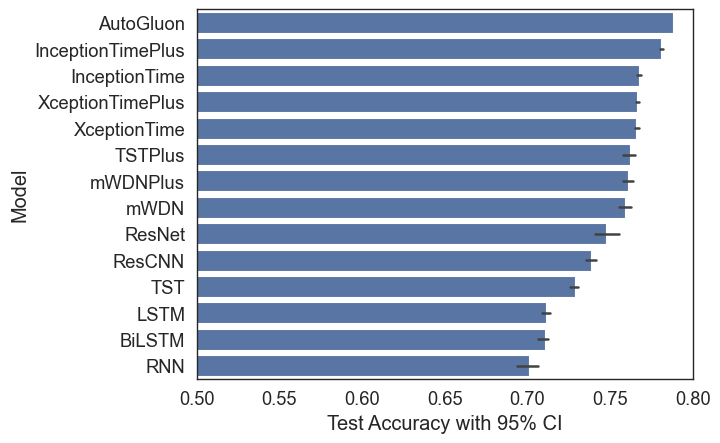

In [6]:
sns.barplot(x='test_accuracy', y='arch', data=results, errorbar='ci', ci=95)
plt.xlim(0.5, 0.8)
plt.ylabel('Model')
plt.xlabel('Test Accuracy with 95% CI')